In [1]:
import pandas as pd
import requests
import folium
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, mapping
from shapely import GeometryCollection, MultiPolygon
import json

In [2]:
PICKLE_PATH = "../data/pickled-pork.pickle"
FSIS_DATA = "../data/fsis-processors-with-location.csv"

In [3]:
# constants for coordinate projections
ALBERS_EQUAL_AREA = "EPSG:9822"
WGS84 = "EPSG:4326"

#### Load Chickens DF

In [4]:
df_large_pork = pd.read_pickle(PICKLE_PATH)

In [5]:
df_large_pork = gpd.GeoDataFrame(df_large_pork).set_geometry("Isochrone")
df_large_pork.head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
40,40,M360 + P360,5118,Smithfield,Smithfield Packaged Meats Corp.,CA,Large,Pork,5.0,4.0,"3049 E. Vernon Avenue, Vernon, CA 90058",34.005840,-118.218488,"POLYGON ((-118.76149 34.66971, -118.76449 34.6..."
41,41,M85O + P17775 + V85O,3228,JBS,Swift Pork Company,IA,Large,Pork,5.0,4.0,"600 South Iowa Avenue, Ottumwa, IA 52501",41.002138,-92.394346,"POLYGON ((-92.35835 41.75450, -92.36014 41.747..."
42,42,M3S + V3S,3239,JBS,Swift Pork Company,IA,Large,Pork,5.0,4.0,"402 North Tenth Avenue, Marshalltown, IA 50158",42.054400,-92.897911,"POLYGON ((-92.90691 42.85252, -92.90852 42.848..."
43,43,M51340 + V51340,6163890,Prestage,Prestage Foods of Iowa,IA,Large,Pork,5.0,4.0,"3183 Hwy 17, Eagle Grove, IA 50533",42.664140,-93.904447,"POLYGON ((-93.98845 43.47435, -93.99145 43.476..."
44,44,M46071 + V46071,6163274,Seaboard,SEABOARD TRIUMPH FOODS,IA,Large,Pork,5.0,4.0,"5555 SEABOARD TRIUMPH PARKWAY, SIOUX CITY, IA ...",42.421072,-96.388160,"POLYGON ((-96.17516 43.20159, -96.17816 43.203..."


In [6]:
# set CRS (coordinate reference system) for the dataframe
df_large_pork.set_crs(WGS84,inplace=True).head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
40,40,M360 + P360,5118,Smithfield,Smithfield Packaged Meats Corp.,CA,Large,Pork,5.0,4.0,"3049 E. Vernon Avenue, Vernon, CA 90058",34.005840,-118.218488,"POLYGON ((-118.76149 34.66971, -118.76449 34.6..."
41,41,M85O + P17775 + V85O,3228,JBS,Swift Pork Company,IA,Large,Pork,5.0,4.0,"600 South Iowa Avenue, Ottumwa, IA 52501",41.002138,-92.394346,"POLYGON ((-92.35835 41.75450, -92.36014 41.747..."
42,42,M3S + V3S,3239,JBS,Swift Pork Company,IA,Large,Pork,5.0,4.0,"402 North Tenth Avenue, Marshalltown, IA 50158",42.054400,-92.897911,"POLYGON ((-92.90691 42.85252, -92.90852 42.848..."
43,43,M51340 + V51340,6163890,Prestage,Prestage Foods of Iowa,IA,Large,Pork,5.0,4.0,"3183 Hwy 17, Eagle Grove, IA 50533",42.664140,-93.904447,"POLYGON ((-93.98845 43.47435, -93.99145 43.476..."
44,44,M46071 + V46071,6163274,Seaboard,SEABOARD TRIUMPH FOODS,IA,Large,Pork,5.0,4.0,"5555 SEABOARD TRIUMPH PARKWAY, SIOUX CITY, IA ...",42.421072,-96.388160,"POLYGON ((-96.17516 43.20159, -96.17816 43.203..."


In [7]:
# simplify the isochrones for improved processing time
df_large_pork['Isochrone Cleaned'] = df_large_pork['Isochrone'].simplify(.05)

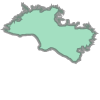

In [9]:
df_large_pork.iloc[0]['Isochrone']

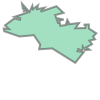

In [10]:
# shows the difference in resolution between the simplified and unsimplified isochrones
df_large_pork.iloc[0]['Isochrone Cleaned']

In [11]:
# list the states that contain poultry plants
df_large_pork.State.unique()

array(['CA', 'IA', 'IL', 'IN', 'KY', 'MI', 'MN', 'MO', 'NC', 'NE', 'OK',
       'PA', 'SD', 'TN', 'VA'], dtype=object)

In [12]:
# reassign the dataframe to df_map for processing later in the notebook
df_map = df_large_pork

### Create Map

In [13]:
# center of the USA: 37.0902° N, 95.7129° W
USA_LAT = 37.0902
USA_LNG = -95.7129

In [14]:
# folium requires these "color mapping functions" to add colors to the map
empty_color = lambda x: {
    "fillColor": "00" # empty
}

one_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

two_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

three_plant_color = lambda x: {
    "fillColor": "#9F2B68" # amaranth
}

four_plant_color = lambda x: {
    "fillColor": "#90ee90" # light green
}

#### Add Plants to Map Layer and Extract Isochrones for Geospatial Processing

In [15]:
# add markers and isochrones to map
isochrones = []
# driving_distance_layer = folium.map.FeatureGroup(name="60 Mile Driving Distance")
plants_layer = folium.map.FeatureGroup(name="Large Poultry Plants")

for index, row in df_map.iterrows():
    lat = str(row['latitude'])
    lng = str(row['longitude'])

    # set up plant tooltip
    name = row['Establishment Name']
    corp = row['Parent Corporation']
    address = row['Full Address']

    # add plant marker to map
    tooltip = folium.map.Tooltip(f"{name}<br>{address}<br>Parent Corporation: {corp}")
    folium.Marker(location=[lat, lng],tooltip=tooltip).add_to(plants_layer)

    isochrone = row['Isochrone Cleaned']
    isochrones.append(isochrone)
    
    # Can add the isochrones to the map, too, but this gets pretty cluttered with the other geospatial data
    # add driving radius isochrone to map layer
    # geojson = folium.GeoJson(row['Isochrone Cleaned'], style_function=empty_color)
    # geojson.add_to(driving_distance_layer)

In [16]:
len(isochrones)

31

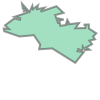

In [17]:
# example isochrone
isochrones[0]

#### Calculate Single-Plant Capture

In [18]:
# create single-plant capture area by removing one plant at a time and saving the area that is unique to that plant
single_plants_shapely = []
for index, poly in enumerate(isochrones):
    others = shapely.unary_union(isochrones[:index] + isochrones[index+1:])
    single_plant = shapely.difference(poly, others)
    single_plants_shapely.append(single_plant)

In [19]:
# create folium layer for single plant capture
single_plant_layer = folium.map.FeatureGroup(name="Access to 1 Plant")
single_plants_combined = shapely.unary_union(single_plants_shapely)
folium.GeoJson(single_plants_combined).add_to(single_plant_layer)

In [20]:
# calculate competitive area for filtering in the next stage
everything = shapely.unary_union(isochrones)
single_plant_combined = shapely.unary_union(single_plants_shapely)
competition_single_plant = shapely.difference(everything, single_plant_combined)

#### Calculate Two Plant Capture

In [21]:
# exclude any plants that are fully in single plant capture area
isochrones_shapely_two_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_single_plant):
        isochrones_shapely_two_plants.append(isochrone)

In [22]:
len(isochrones_shapely_two_plants)

24

In [23]:
# logic here is similar to single plant capture with just a bit more complexity since we are now looking at two plant capture so we need to do a nested loop
two_plants_shapely = []
for i in range(len(isochrones_shapely_two_plants)):
    for j in range(i+1, len(isochrones_shapely_two_plants)):
        plant_1 = isochrones_shapely_two_plants[i]
        plant_2 = isochrones_shapely_two_plants[j]

        # check if there's an intersection between the areas
        if not plant_1.intersection(plant_2):
            continue
        else:
            two_plant_area = shapely.unary_union([plant_1,plant_2])

        # exclude first plant
        other_plants = isochrones_shapely_two_plants[:i]
        # exclude second plant
        other_plants += isochrones_shapely_two_plants[i+1:j]
        other_plants += isochrones_shapely_two_plants[j+1:]

        # find the area where there's only two plants
        others_combined = shapely.unary_union(other_plants)
        captured_area = shapely.difference(two_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
        # remove the area that is captured by only one of the plants
        captured_area = shapely.difference(captured_area, single_plant_combined)
        if captured_area:
            two_plants_shapely.append(captured_area)


In [24]:
len(two_plants_shapely)

34

In [25]:
two_plant_layer = folium.map.FeatureGroup(name="Access to 2 Plants")
two_plants_combined = shapely.unary_union(two_plants_shapely)
folium.GeoJson(two_plants_combined,style_function=two_plant_color).add_to(two_plant_layer)

In [26]:
# calculate competitive area for filtering in the next stage
competition_two_plant = shapely.difference(competition_single_plant, two_plants_combined)

#### Calculate Three Plant Competition Area

In [27]:
# exclude any plants that don't intersect with the competition area
isochrones_shapely_three_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_two_plant):
        isochrones_shapely_three_plants.append(isochrone)

In [28]:
len(isochrones_shapely_three_plants)

16

In [29]:
# same idea as previous steps, now we just need to do this for three plants
three_plants_shapely = []
for i in range(len(isochrones_shapely_three_plants)):
    for j in range(i+1, len(isochrones_shapely_three_plants)):
        for k in range(j+1, len(isochrones_shapely_three_plants)):
            plant_1 = isochrones_shapely_three_plants[i]
            plant_2 = isochrones_shapely_three_plants[j]
            plant_3 = isochrones_shapely_three_plants[k]

            # check if there's an intersection between the areas
            if not plant_1.intersection(plant_2).intersection(plant_3):
                continue
            else:
                three_plant_area = shapely.unary_union([plant_1,plant_2,plant_3])

            # exclude first plant
            other_plants = isochrones_shapely_three_plants[:i]
            # exclude second plant
            other_plants += isochrones_shapely_three_plants[i+1:j]
            other_plants += isochrones_shapely_three_plants[j+1:k]
            # exclude third plant
            other_plants += isochrones_shapely_three_plants[k+1:]

            # find the area where there's only two plants
            others_combined = shapely.unary_union(other_plants)
            captured_area = shapely.difference(three_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
            # remove the area that is captured by only one of the plants
            captured_area = shapely.difference(captured_area, single_plant_combined)
            # remove the area that is captured by only two of the plants
            captured_area = shapely.difference(captured_area, two_plants_combined)
            if captured_area:
                three_plants_shapely.append(captured_area)


In [30]:
len(three_plants_shapely)

13

In [31]:
# create three plant layer
three_plant_layer = folium.map.FeatureGroup(name="Access to 3 Plants")
three_plants_combined = shapely.unary_union(three_plants_shapely)
folium.GeoJson(three_plants_combined,style_function=three_plant_color).add_to(three_plant_layer)

#### Calculate 4+ Plant Competition Area

In [32]:
# 4+ plants is everything else that is left over
four_plants_combined = shapely.difference(everything, single_plant_combined)
four_plants_combined = shapely.difference(four_plants_combined, two_plants_combined)
four_plants_combined = shapely.difference(four_plants_combined.buffer(0), three_plants_combined.buffer(0)) # add buffer(0) to handle floating point errors

In [33]:
# create folium layer
four_plant_layer = folium.map.FeatureGroup(name="Access to 4+ Plants")
folium.GeoJson(four_plants_combined,style_function=four_plant_color).add_to(four_plant_layer)

#### Calculate Captured Area

In [34]:
from pyproj import Geod

In [35]:
# example of calculating areas using pyproj
geod = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod.geometry_area_perimeter(single_plant_combined)

In [36]:
# negative area just depends on whether the points are clockwise or counterclockwise — need to be careful with absolute values here
geod.geometry_area_perimeter(everything)

(-402865548924.16516, 15322803.603107141)

In [37]:
# example calculation checking the ratio areas in each of the "capture zones"
single_plant_area = abs(geod.geometry_area_perimeter(single_plant_combined)[0]/geod.geometry_area_perimeter(everything)[0])
two_plant_area = abs(geod.geometry_area_perimeter(two_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
three_plant_area = abs(geod.geometry_area_perimeter(three_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
four_plant_area = abs(geod.geometry_area_perimeter(four_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])

In [38]:
single_plant_area, two_plant_area, three_plant_area, four_plant_area

(0.7612558756014488, 0.22141150061600923, 0.01733262378254216, 0.0)

In [39]:
# this should sum to 1 (or very close to it)
single_plant_area + two_plant_area + three_plant_area + four_plant_area

1.0000000000000002

#### Display Map

In [40]:
# create actual folium map object
m = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [41]:
# add each of our previously created layers to the folium map
plants_layer.add_to(m)
single_plant_layer.add_to(m)
two_plant_layer.add_to(m)
three_plant_layer.add_to(m)
four_plant_layer.add_to(m)
folium.map.LayerControl().add_to(m) # you need to add layer control *last* or else nothing will show up on the map
m

##### Save Map

In [42]:
# don't need to do this unless you want to actually save the map
# export html of map
m.save("../html/poultry-map-smoothed.html")

#### Include State Level Data

RAFI plans to examine this data on the state level. So, we join our previous GeoJSONs with state GeoJSONs.

In [43]:
us_states = gpd.read_file("../data/gz_2010_us_040_00_500k.json").set_crs(WGS84)

In [44]:
us_states.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


In [45]:
# print the crs information of the states dataframe
us_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
# Example: you can calculate the centroid of a specific state
print(us_states.iloc[0]['geometry'].centroid)

POINT (-69.22532171969658 45.36948088392073)


In [52]:
# Which states do we have again?
df_large_pork.State.unique()

array(['CA', 'IA', 'IL', 'IN', 'KY', 'MI', 'MN', 'MO', 'NC', 'NE', 'OK',
       'PA', 'SD', 'TN', 'VA'], dtype=object)

In [49]:
abb2state = {
    'CA': "California", 
    'IA': "Iowa", 
    'IL': "Illinois", 
    'IN': "Indiana", 
    'KY': "Kentucky",
    'MI': "Michigan", 
    'MN': "Minnesota", 
    'MO': "Missouri", 
    'NC': "North Carolina", 
    'NE': "Nebraska", 
    'OK': "Oklahoma", 
    'PA': "Pennsylvania", 
    'SD': "South Dakota", 
    'TN': "Tennessee",
    'VA': "Virginia",
}

In [53]:
# highlight function (change displayed on hover)
# again, Folium uses these kinda weird style functions that you pass when creating the layer
state_function = lambda x: {
  'color': 'red', # stroke becomes red
  'fillColor': '#00000000',
  # 'opacity' : 0.9,
  # 'weight': 4,
  'dashArray' : '3, 6' # transforms the solid stroke to a dashed stroke
}

In [54]:
# new map object that we will map state level data on
mm = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [55]:
# initialize new GeoPandas dataframe that we will use to add our state level geojsons to
df_states = gpd.GeoDataFrame()

In [56]:
# We want to filter plants by corporation as well, so we create a list of dataframes where each dataframe in the list contains plant data for one corporation
corp_dfs = []
for corp in df_large_pork['Parent Corporation'].unique():
    df = df_large_pork[df_large_pork['Parent Corporation'] == corp]
    corp_dfs.append(df)

In [57]:
len(corp_dfs)

9

In [58]:
states = df_large_pork.State.unique()

In [59]:
len(states)

15

In [60]:
# let's check to make sure that our corporate dataframes were filtered properly
corp_dfs[0].head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone,Isochrone Cleaned
40,40,M360 + P360,5118,Smithfield,Smithfield Packaged Meats Corp.,CA,Large,Pork,5.0,4.0,"3049 E. Vernon Avenue, Vernon, CA 90058",34.005840,-118.218488,"POLYGON ((-118.76149 34.66971, -118.76449 34.6...","POLYGON ((-118.76149 34.66971, -118.74529 34.5..."
45,45,M717 + P19051 + V717,3272,Smithfield,Smithfield Fresh Meats Corp.,IA,Large,Pork,5.0,4.0,"800 Industrial Drive, Denison, IA 51442",42.027117,-95.360263,"POLYGON ((-95.55226 42.79599, -95.55317 42.792...","POLYGON ((-95.55226 42.79599, -95.70888 42.678..."
51,51,M717M,2506,Smithfield,Smithfield Fresh Meats Corp.,IL,Large,Pork,4.0,4.0,"1220 North 6th Street, Monmouth, IL 61462",40.927153,-90.641610,"POLYGON ((-90.49161 41.69316, -90.49399 41.673...","POLYGON ((-90.49161 41.69316, -90.58461 41.619..."
60,60,M320M + V320,3537,Smithfield,Smithfield Fresh Meats Corp.,MO,Large,Pork,5.0,4.0,"22123 Highway 5, Milan, MO 63556",40.217511,-93.118696,"POLYGON ((-92.83670 40.94695, -92.83836 40.943...","POLYGON ((-92.83670 40.94695, -92.89370 40.826..."
61,61,M18079 + P27232,728,Smithfield,Smithfield Fresh Meats Corp.,NC,Large,Pork,5.0,4.0,"15855 Highway 87 West, Tar Heel, NC 28392",34.746698,-78.804715,"POLYGON ((-79.14372 35.50051, -79.14672 35.502...","POLYGON ((-79.14372 35.50051, -79.33593 35.331..."


In [61]:
# create geometry for specific corporation
# join everything in each corporate dataframe then add to a new list of geojsons
corps_joined = []
for corp_df in corp_dfs:
    corp_geomtery = corp_df['Isochrone Cleaned'].unary_union
    corp_data = {
        "parent_corporation": corp_df.iloc[0]["Parent Corporation"],
        "geometry": corp_geomtery,
    }
    corps_joined.append(corp_data)

In [62]:
# make one dataframe from list of dataframes
df_corps_joined = gpd.GeoDataFrame(corps_joined)

In [63]:
# let's make sure that this is what we expect
df_corps_joined.head()

,parent_corporation,geometry
0,Smithfield,"MULTIPOLYGON (((-118.53949 34.55763, -118.4367..."
1,JBS,"MULTIPOLYGON (((-85.77617 38.91488, -85.64404 ..."
2,Prestage,"POLYGON ((-93.98845 43.47435, -94.18645 43.331..."
3,Seaboard,"MULTIPOLYGON (((-101.31948 37.36100, -101.1274..."
4,Tyson,"MULTIPOLYGON (((-88.99836 36.74935, -88.69476 ..."


In [64]:
# now, we want to intersect the corporate geojsons with the state geojsons so we have a geojson for each valid corporation/state pairing
corp_state_geojsons = []
# create layers for each corporation in each state
for i, corp in df_corps_joined.iterrows():
    # create an intersection with each state's monopsony area
    for state in states:
        state_name = abb2state[state]
        state_layer = folium.map.FeatureGroup(name=state_name, show=False)
        state_geometry = us_states[us_states["NAME"] == state_name]['geometry'].to_crs(WGS84)
        state_center = state_geometry.to_crs(ALBERS_EQUAL_AREA).centroid.to_crs(WGS84)

        one_plant = shapely.intersection(single_plant_combined,state_geometry).set_crs(WGS84).iloc[0]
        one_plant_one_corp_one_state = shapely.intersection(one_plant,corp.geometry)

        # convert geometry collections to multipolygons
        if isinstance(one_plant_one_corp_one_state, GeometryCollection):
            one_plant = MultiPolygon([g for g in one_plant_one_corp_one_state.geoms if isinstance(g, Polygon)])

        if one_plant_one_corp_one_state:
            one_plant_one_state_data = {
                "state": state_name,
                "geometry": one_plant_one_corp_one_state,
                "parent_corporation": corp.parent_corporation
            }

            corp_state_geojsons.append(one_plant_one_state_data)

In [65]:
len(corp_state_geojsons)

40

In [66]:
df_corp_state = gpd.GeoDataFrame(corp_state_geojsons)

In [67]:
# let's make sure this is what we expect
df_corp_state

,state,geometry,parent_corporation
0,California,"POLYGON ((-117.91439 34.48284, -118.08661 34.4...",Smithfield
1,Iowa,GEOMETRYCOLLECTION (POLYGON ((-95.54079 41.497...,Smithfield
2,Illinois,GEOMETRYCOLLECTION (POLYGON ((-91.09485 40.816...,Smithfield
3,Minnesota,GEOMETRYCOLLECTION (POLYGON ((-96.42454 44.069...,Smithfield
4,Missouri,GEOMETRYCOLLECTION (POLYGON ((-93.69773 40.376...,Smithfield
5,North Carolina,"MULTIPOLYGON (((-78.08266 34.37176, -78.07765 ...",Smithfield
6,Nebraska,GEOMETRYCOLLECTION (POLYGON ((-96.18222 40.334...,Smithfield
7,South Dakota,GEOMETRYCOLLECTION (POLYGON ((-97.80321 43.664...,Smithfield
8,Virginia,"MULTIPOLYGON (((-76.47307 37.39619, -76.47279 ...",Smithfield
9,Iowa,GEOMETRYCOLLECTION (POLYGON ((-93.49487 41.542...,JBS


In [68]:
# Export corporate/state geojsons to file
df_corp_state.to_file("../data/all_states_with_parent_corp.geojson", driver="GeoJSON")